<footer id="footer"></footer>

# Cleaned Toxic Comments

![](https://i.ibb.co/pjcBRMR/bbc87fcc-3bb9-422a-a925-60ae8f17b019.jpg)

Discussing things you care about can be difficult. The threat of abuse and harassment online means that many people stop expressing themselves and give up on seeking different opinions. Platforms struggle to effectively facilitate conversations, leading many communities to limit or completely shut down user comments.

We have several target features, but let us work only with toxic in this data because of kernel limits (and try to use simple models - now voting classifiers - only RandomForest, SGD and try some BERT)


**Due to the computational limitations of the kernel - i have to abandon voting during classification and choose only one target feature. I hope the procedure will be useful to someone. It is just a baseline for beginners, thank you for reading**

## Preprocessing

### Imports

In [1]:
%%capture
!pip install transformers;

In [2]:
%%capture
!pip install wordcloud;

In [3]:
%%capture
!pip install tqdm;

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.utils import shuffle


import torch
import transformers
from wordcloud import WordCloud


import warnings
import seaborn as sns
from tqdm import notebook
from tqdm import tqdm

sns.set_style('darkgrid')
nltk.download('punkt')
nltk.download('wordnet')
warnings.filterwarnings('ignore')
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

np.random.seed(42)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Downloading data and review

In [5]:
train = pd.read_csv('../input/cleaned-toxic-comments/train_preprocessed.csv')
train.drop(['set', 'id', 'toxicity'], axis=1, inplace=True)
display(train.head())
display(train.columns)

,comment_text,identity_hate,insult,obscene,severe_toxic,threat,toxic
0,explanation why the edits made under my userna...,0.0,0.0,0.0,0.0,0.0,0.0
1,d aww he matches this background colour i m s...,0.0,0.0,0.0,0.0,0.0,0.0
2,hey man i m really not trying to edit war it...,0.0,0.0,0.0,0.0,0.0,0.0
3,more i can t make any real suggestions on im...,0.0,0.0,0.0,0.0,0.0,0.0
4,you sir are my hero any chance you remember...,0.0,0.0,0.0,0.0,0.0,0.0


Index(['comment_text', 'identity_hate', 'insult', 'obscene', 'severe_toxic',
       'threat', 'toxic'],
      dtype='object')

the column `comment_text` contains the text of the comment, and `identity_hate`, `insult`, `obscene`, `severe_toxic`, `threat`, `toxic` — target features

Check the gaps

In [6]:
train.isna().mean()

comment_text     0.0
identity_hate    0.0
insult           0.0
obscene          0.0
severe_toxic     0.0
threat           0.0
toxic            0.0
dtype: float64

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   comment_text   159571 non-null  object 
 1   identity_hate  159571 non-null  float64
 2   insult         159571 non-null  float64
 3   obscene        159571 non-null  float64
 4   severe_toxic   159571 non-null  float64
 5   threat         159571 non-null  float64
 6   toxic          159571 non-null  float64
dtypes: float64(6), object(1)
memory usage: 8.5+ MB


The dataset contains 159571 lines, the data types correspond to the desired ones

In [8]:
train.duplicated().sum()

717

For convenience, we will convert the text to lower case

In [9]:
train['comment_text'] = train['comment_text'].str.lower()

In [10]:
train.head()

,comment_text,identity_hate,insult,obscene,severe_toxic,threat,toxic
0,explanation why the edits made under my userna...,0.0,0.0,0.0,0.0,0.0,0.0
1,d aww he matches this background colour i m s...,0.0,0.0,0.0,0.0,0.0,0.0
2,hey man i m really not trying to edit war it...,0.0,0.0,0.0,0.0,0.0,0.0
3,more i can t make any real suggestions on im...,0.0,0.0,0.0,0.0,0.0,0.0
4,you sir are my hero any chance you remember...,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
cols = ['identity_hate', 'insult', 'obscene', 'severe_toxic', 'threat', 'toxic']
for col in cols:
  display(train[col].value_counts(normalize=True))

0.0    0.991195
1.0    0.008805
Name: identity_hate, dtype: float64

0.0    0.950636
1.0    0.049364
Name: insult, dtype: float64

0.0    0.947052
1.0    0.052948
Name: obscene, dtype: float64

0.0    0.990004
1.0    0.009996
Name: severe_toxic, dtype: float64

0.0    0.997004
1.0    0.002996
Name: threat, dtype: float64

0.0    0.904156
1.0    0.095844
Name: toxic, dtype: float64

**Conclusion:** Primary transformations were made, checked for gaps and duplicates. we observe an imbalance in the target class

We need to transform the text, get tokens, and also clear lines of characters. We will make the transformations through the function and library `nltk` and` re`

In [12]:
def text_preprocessing(text):
    tokenized = nltk.word_tokenize(text)
    joined = ' '.join(tokenized)
    text_only = re.sub(r'[^a-zA-Z]', ' ', joined)
    final = ' '.join(text_only.split())
    return final

In [13]:
tqdm.pandas() 
train['token_text'] = train['comment_text'].progress_apply(text_preprocessing)

100%|██████████| 159571/159571 [00:53<00:00, 2959.48it/s]


We got tokens of words, we can continue working with the set

In [14]:
corpus_lemm = train['token_text']

In [15]:
corpus_lemm[0]

'explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now'

Received a body for further processing

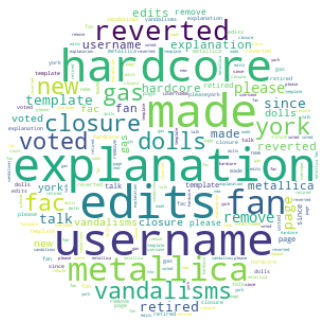

In [16]:
x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 150 ** 2
mask = 255 * mask.astype(int)

wc = WordCloud(background_color="white", 
               random_state=42, mask=mask, repeat=True,
               stopwords=stopwords).generate(corpus_lemm[0])

plt.figure(figsize=(15, 10), dpi=42)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

**Conclusion:** Transformed the dataset and got word lemmas. In the word cloud, the most common words are explanation, dolls, edits - let's try to train the models to predict the toxicity of the text.

We going to use an Random Forest and SGD classifier, and we will also use the Word2vec class of BERT models to obtain and predict embeddings - perhaps we will be able to improve the results of the basic models

To speed up the BERT learning process, only a part of the dataset will be transmitted, which should have a definite effect on the result. Also we will use only toxic target

## Model training

there is a strong class imbalance. Let's try to go in two ways:

- train the model on the network using **downsampling**
- train the model with the parameter **class_weight = 'balanced'**

### Preparing characteristics


Let's select from the set date the target feature and the training feature - the text

In [17]:
train.head()

,comment_text,identity_hate,insult,obscene,severe_toxic,threat,toxic,token_text
0,explanation why the edits made under my userna...,0.0,0.0,0.0,0.0,0.0,0.0,explanation why the edits made under my userna...
1,d aww he matches this background colour i m s...,0.0,0.0,0.0,0.0,0.0,0.0,d aww he matches this background colour i m se...
2,hey man i m really not trying to edit war it...,0.0,0.0,0.0,0.0,0.0,0.0,hey man i m really not trying to edit war it s...
3,more i can t make any real suggestions on im...,0.0,0.0,0.0,0.0,0.0,0.0,more i can t make any real suggestions on impr...
4,you sir are my hero any chance you remember...,0.0,0.0,0.0,0.0,0.0,0.0,you sir are my hero any chance you remember wh...


In [18]:
features = train['token_text']
target = train['toxic']

Divide our sample, denote the test size as 25%

In [19]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=42)

Let's write a function that allows you to achieve a balance of the class, through downsampling

In [20]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_sample = features_zeros.sample(frac=0.1, random_state=42)
    target_sample = target_zeros.sample(frac=0.1, random_state=42)
    
    features_downsampled = pd.concat([features_sample] + [features_ones])
    target_downsampled = pd.concat([target_sample] + [target_ones])
    
    features_downsampled = shuffle(features_downsampled, random_state=42)
    target_downsampled = shuffle(target_downsampled, random_state=42)
    
    return features_downsampled, target_downsampled

We will receive new sets

In [21]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

print(features_downsampled.shape)
print(target_downsampled.shape)

(22299,)
(22299,)


In [22]:
target_downsampled.value_counts(normalize=True)

1.0    0.514776
0.0    0.485224
Name: toxic, dtype: float64

The imbalance is insignificant, with such a set, you can try to train the model. First, let's get the TD-IDF measure for the new set.

In [23]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
tf_idf = count_tf_idf.fit_transform(features_downsampled)

print("Learning Matrix Size:", tf_idf.shape)

Learning Matrix Size: (22299, 48434)


In [24]:
model_name = []
fscore = []

### Training a random forest with downsampling


Train an ensemble of models using the downsampling technique

In [25]:
X_train_ans = tf_idf
y_train_ans = target_downsampled

In [26]:
%%time

rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)



X_test_ans = count_tf_idf.transform(features_test)

rnd_clf.fit(X_train_ans, y_train_ans)
predict = rnd_clf.predict(X_test_ans)
f_score = f1_score(predict, target_test)

print('{}'.format(f_score))

0.6455312702878165
CPU times: user 8.02 s, sys: 17.1 ms, total: 8.04 s
Wall time: 8.05 s


F1 measure is not good, the model converges poorly on the test - let's try learning without downsampling with class balance and SGD


In [27]:
model_name.append(str(rnd_clf.__class__.__name__)+str(' ')+str('downsampling)'))
fscore.append(round(f_score, 2))

### Training a random forest without downsampling

Let's train a model based on the same ensemble, but instead of a balanced set, we use the basic lemmatized one and set the class weight as balanced 

In [28]:
count_tf = TfidfVectorizer(stop_words=stopwords)
tf_idf_new = count_tf.fit_transform(features_train)

In [29]:
%%time
X_train = tf_idf_new
y_train = target_train

X_test = count_tf.transform(features_test)


rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42, 
                            class_weight='balanced')



rnd_clf.fit(X_train, y_train)
predict_new = rnd_clf.predict(X_test)

CPU times: user 15min 42s, sys: 800 ms, total: 15min 43s
Wall time: 15min 43s


In [30]:
f_score = f1_score(predict_new, target_test)
print(f_score)

0.6771180787191462



With this approach, it was possible to increase the F1 measure

In [31]:
model_name.append(str(rnd_clf.__class__.__name__)+str(' ')+str('class_weight balanced'))
fscore.append(round(f_score, 2))

### Train SGD model without downsampling

Let's try the stochastic gradient descent model separately, without downsampling.

In [32]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
tf_idf = count_tf_idf.fit_transform(features_downsampled)

print("Matrix size:", tf_idf.shape)

Matrix size: (22299, 48434)


In [33]:
X_train = tf_idf
y_train = target_downsampled

In [34]:
sgb_clf = SGDClassifier(l1_ratio=0.1, random_state=42,
                            class_weight='balanced')

In [35]:
%%time
sgb_clf.fit(X_train, y_train)

X_test = count_tf_idf.transform(features_test)

predict = sgb_clf.predict(X_test)
f_score = f1_score(predict_new, target_test)
print(f_score)

0.6771180787191462
CPU times: user 2.03 s, sys: 5 ms, total: 2.04 s
Wall time: 2.06 s


The result is also satisfactory, but it should be noted that the learning rate is much higher and, accordingly, it is more optimal to use this model for our purposes.

In [36]:
model_name.append(str(sgb_clf.__class__.__name__)+str(' ')+str('class_weight balanced'))
fscore.append(round(f_score, 2))

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

### Train BERT Model (DistilBertModel)

To train the model with pretraining using BERT, we will build a new set, balanced, since we will have to transfer an order of magnitude fewer rows for training, which is not an entirely adequate performance estimate

Let's create samples for BERT and remove the class imbalance in the training sample. We will postpone the test sample and will not touch it.

In [37]:
features = train['comment_text']
target = train['toxic']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=42)

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

target_downsampled.value_counts(normalize=True).to_frame()

,toxic
1.0,0.514776
0.0,0.485224


Let's create a set from the training balanced sample, remove duplicates from it and take a sample of 500 values

In [38]:
df_bert = features_downsampled.to_frame().join(
    target_downsampled.to_frame())
df_bert.head()

,comment_text,toxic
78488,wikipedia appears to work on the basis that a ...,1.0
133294,yeah like the fact that he is gay i mean he...,1.0
18393,warning for doing nothing fuck u why the f...,1.0
115222,hey fuck you cunt bag you dont own wikpedia...,1.0
54584,you little bitch trying to get away with your ...,1.0


In [39]:
df_bert.duplicated().sum()

47

In [40]:
df_bert.drop_duplicates(inplace=True)
df_bert.duplicated().sum()

0

In [41]:
df_bert[df_bert.index == 115222]

,comment_text,toxic
115222,hey fuck you cunt bag you dont own wikpedia...,1.0


Thus, we got a new set, from which we will take slices, while deleting all duplicates, checking one index in order to make sure that the set was assembled adequately

In [42]:
df_comm = df_bert.sample(300).reset_index(
    drop=True)
df_comm.head()

,comment_text,toxic
0,dude you crazy dude you are totally not cool...,1.0
1,crapman is a murdering cunt,1.0
2,ooh i m scared fuck you,1.0
3,ok no problem i d rather ask someone with a ...,0.0
4,hi believe it or not i don t enjoy cruising ...,0.0


In [43]:
df_comm['toxic'].value_counts(normalize=True).to_frame()

,toxic
1.0,0.516667
0.0,0.483333


We got a fairly balanced sample.

We transform our signs in order to obtain embeddings

In [44]:
configuration = transformers.DistilBertConfig()
model = transformers.DistilBertModel(configuration)
configuration = model.config

pretrained_weights = 'distilbert-base-uncased'

tokenizer_class = transformers.DistilBertTokenizer

It is worth noting that the model is trained to work with sentences up to 512 characters. It is necessary to cut our offers if they exceed this limit. It can also affect the results

In [45]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)

tokenized = df_comm['comment_text'].apply(
    lambda x: tokenizer.encode(x[:512], add_special_tokens=True))

padded = np.array([i + [0]*(512 - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [46]:
len(padded[0])

512

In [47]:
padded.shape, attention_mask.shape

((300, 512), (300, 512))

In [48]:
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/3 [00:00<?, ?it/s]

Create training and target datasets for our model

In [49]:
X_train = np.concatenate(embeddings)
y_train = df_comm['toxic'][:padded.shape[0]]

We will check visually whether the target classes were selected correctly

In [50]:
y_train.values[:50]

array([1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0.,
       1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1.])

In [51]:
df_comm['toxic'].values[:50]

array([1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0.,
       1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1.])

Check the sets for the form

In [52]:
X_train.shape, y_train.shape

((300, 768), (300,))

In [53]:
y_train.value_counts(normalize=True).to_frame()

,toxic
1.0,0.516667
0.0,0.483333


The target feature is balanced on the training sample

Let's prepare a test sample. Let's take 200 random values ​​and get embeddings for the test

In [54]:
test = features_test.to_frame().join(
    target_test.to_frame()).sample(200).reset_index(
    drop=True)
test.head()

,comment_text,toxic
0,nixon s enemies list i noticed that you comp...,0.0
1,how about this go fuck yourself,1.0
2,fuck you block me you faggot pussy,1.0
3,user aperson promised me some help,0.0
4,david oh wow rob a bank and why would we ja...,1.0


In [55]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)

tokenized = test['comment_text'].apply(
    lambda x: tokenizer.encode(x[:512], add_special_tokens=True))

padded = np.array([i + [0]*(512 - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [56]:
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/2 [00:00<?, ?it/s]

In [57]:
X_test = np.concatenate(embeddings)
y_test = test['toxic'][:X_test.shape[0]]

In [58]:
y_test.value_counts(normalize=True).to_frame()

,toxic
0.0,0.92
1.0,0.08


There is an imbalance of classes in the test sample. Let's train a logistic regression model, with a balance

In [59]:
%%time
log_clf = LogisticRegression(solver="liblinear", random_state=42,
                             class_weight='balanced')

log_clf.fit(X_train, y_train)

CPU times: user 43.1 ms, sys: 894 µs, total: 44 ms
Wall time: 46.7 ms


LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')

In [60]:
predict = log_clf.predict(X_test)

In [61]:
f_score = f1_score(predict, y_test)
print(f_score)

0.25000000000000006


Unfortunately, we got a rather low result. But this fact is due to the fact that in order to reduce the training time, we had to transfer not the entire set for training, and we had to cut off the sentences that the model could work with them, which could affect the context

In [62]:
model_name.append(str(log_clf.__class__.__name__)+str(' ')+str('BERT'))
fscore.append(round(f_score, 2))

### Sanity check

Let's build a constant model. She will predict 1 - toxic comment everywhere, since our goal is to identify them.

In [63]:
dummy = DummyClassifier(random_state=42, strategy='constant', constant=1)

In [64]:
dummy.fit(features_train, target_train)
dummy_pred = dummy.predict(features_test)

In [65]:
f1_const = f1_score(target_test, dummy_pred)

print("Const:", f1_const)

Const: 0.17456758488148622


In [66]:
model_name.append(str(dummy.__class__.__name__)+str(' ')+str('const 1'))
fscore.append(round(f1_const, 2))

## Summary

In [67]:
summary = pd.DataFrame(
    { 'model' : model_name , 'F1' : fscore }
    ).reset_index( drop = True ).sort_values(by='F1', ascending=False)

summary.style.highlight_max( 'F1' , color = 'green' , axis = 0 )


,model,F1
1,RandomForestClassifier class_weight balanced,0.680000
2,SGDClassifier class_weight balanced,0.680000
0,RandomForestClassifier downsampling),0.650000
3,LogisticRegression BERT,0.250000
4,DummyClassifier const 1,0.170000


Thus, acceptable results were obtained on randomforest and a model based on the SGB algorithm - they adequately correlate with both the operating time and the quality of the F1 measure. Logistic regression based on BERT to classify long texts such as comments for these purposes is not worth it - you have to truncate the text, which can affect the context, you have to limit the amount of data for training and prediction.


I believe that for these purposes the best model is based on stochastic gradient descent from the sklearn library - SGDClassifier with the class weights parameter set - as 'balanced'


---
<font size="1">
ArtyKraftyy
</font>     
